In [23]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
postcodes_missing = pd.read_csv('flood_tool/example_data/postcodes_missing_data.csv')
postcodes_unlabelled = pd.read_csv('flood_tool/example_data/postcodes_unlabelled.csv')
typical_day = pd.read_csv('flood_tool/example_data/typical_day.csv')
wet_day = pd.read_csv('flood_tool/example_data/wet_day.csv')

In [25]:
district_data = pd.read_csv('flood_tool/resources/district_data.csv')
postcodes_labelled = pd.read_csv('flood_tool/resources/postcodes_labelled.csv')
sector_data = pd.read_csv('flood_tool/resources/sector_data.csv')
stations = pd.read_csv('flood_tool/resources/stations.csv')

In [26]:
postcodes_unlabelled.head()

,postcode,easting,northing,soilType,elevation,nearestWatercourse,distanceToWatercourse,localAuthority
0,PO9 5EA,472101,108419,Unsurveyed/Urban,40,NaN,1530.0,Havant
1,EX15 3XE,313905,113519,Luvisols,130,River Culm,310.0,Mid Devon
2,PO14 4RJ,452325,106646,Unsurveyed/Urban,40,NaN,1270.0,Fareham
3,SE24 9UX,532008,174437,Unsurveyed/Urban,20,River Thames,5290.0,Lambeth
4,BS20 9PR,346765,176083,Unsurveyed/Urban,10,NaN,640.0,North Somerset


In [27]:
print('Missing for postcodes_labelled', postcodes_labelled.shape, postcodes_labelled.isnull().sum())

Missing for postcodes_labelled (80000, 11) postcode                     0
easting                      0
northing                     0
soilType                     0
elevation                    0
nearestWatercourse       30091
distanceToWatercourse        0
localAuthority               0
riskLabel                    0
medianPrice               6202
historicallyFlooded          0
dtype: int64


In [28]:
from flood_tool.geo import get_gps_lat_long_from_easting_northing
coordinates_lat = get_gps_lat_long_from_easting_northing(postcodes_labelled['easting'], postcodes_labelled['northing'])
coordinates_df = pd.DataFrame({
    'Latitude': coordinates_lat[0],
    'Longitude': coordinates_lat[1]
})
postcodes_labelled = pd.concat([postcodes_labelled, coordinates_df], axis=1)
postcodes_labelled.drop(columns=['easting', 'northing'], inplace=True)
postcodes_labelled.head()

,postcode,soilType,elevation,nearestWatercourse,distanceToWatercourse,localAuthority,riskLabel,medianPrice,historicallyFlooded,Latitude,Longitude
0,BA1 1AL,Unsurveyed/Urban,20,River Avon,1240.0,Bath and North East Somerset,5,621800.0,1,51.379625,-2.363284
1,BA1 1AN,Unsurveyed/Urban,20,River Avon,1550.0,Bath and North East Somerset,3,577900.0,0,51.379000,-2.358926
2,BA1 1AR,Unsurveyed/Urban,20,River Avon,1540.0,Bath and North East Somerset,5,533300.0,1,51.378585,-2.359282
3,BA1 1BG,Unsurveyed/Urban,30,River Avon,1450.0,Bath and North East Somerset,1,563600.0,0,51.383215,-2.359763
4,BA1 1BH,Unsurveyed/Urban,30,River Avon,1410.0,Bath and North East Somerset,1,570800.0,0,51.382862,-2.360321


1. task 1: postocodes_labelled.shape: predict risk flood, want to have high recall. 

In [29]:
postcodes_labelled.head()



,postcode,soilType,elevation,nearestWatercourse,distanceToWatercourse,localAuthority,riskLabel,medianPrice,historicallyFlooded,Latitude,Longitude
0,BA1 1AL,Unsurveyed/Urban,20,River Avon,1240.0,Bath and North East Somerset,5,621800.0,1,51.379625,-2.363284
1,BA1 1AN,Unsurveyed/Urban,20,River Avon,1550.0,Bath and North East Somerset,3,577900.0,0,51.379000,-2.358926
2,BA1 1AR,Unsurveyed/Urban,20,River Avon,1540.0,Bath and North East Somerset,5,533300.0,1,51.378585,-2.359282
3,BA1 1BG,Unsurveyed/Urban,30,River Avon,1450.0,Bath and North East Somerset,1,563600.0,0,51.383215,-2.359763
4,BA1 1BH,Unsurveyed/Urban,30,River Avon,1410.0,Bath and North East Somerset,1,570800.0,0,51.382862,-2.360321


<Axes: >

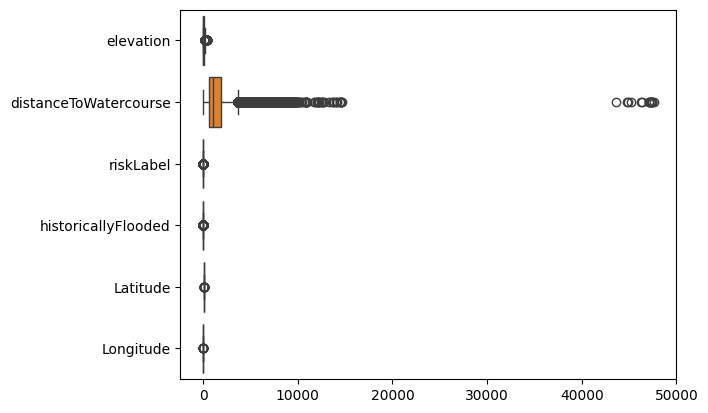

In [30]:
sns.boxplot(postcodes_labelled.drop(columns='medianPrice'), orient='h' )

elevation, robust scaler, distance to watercourse robust scaler, log on median and distance to Watercourse. 

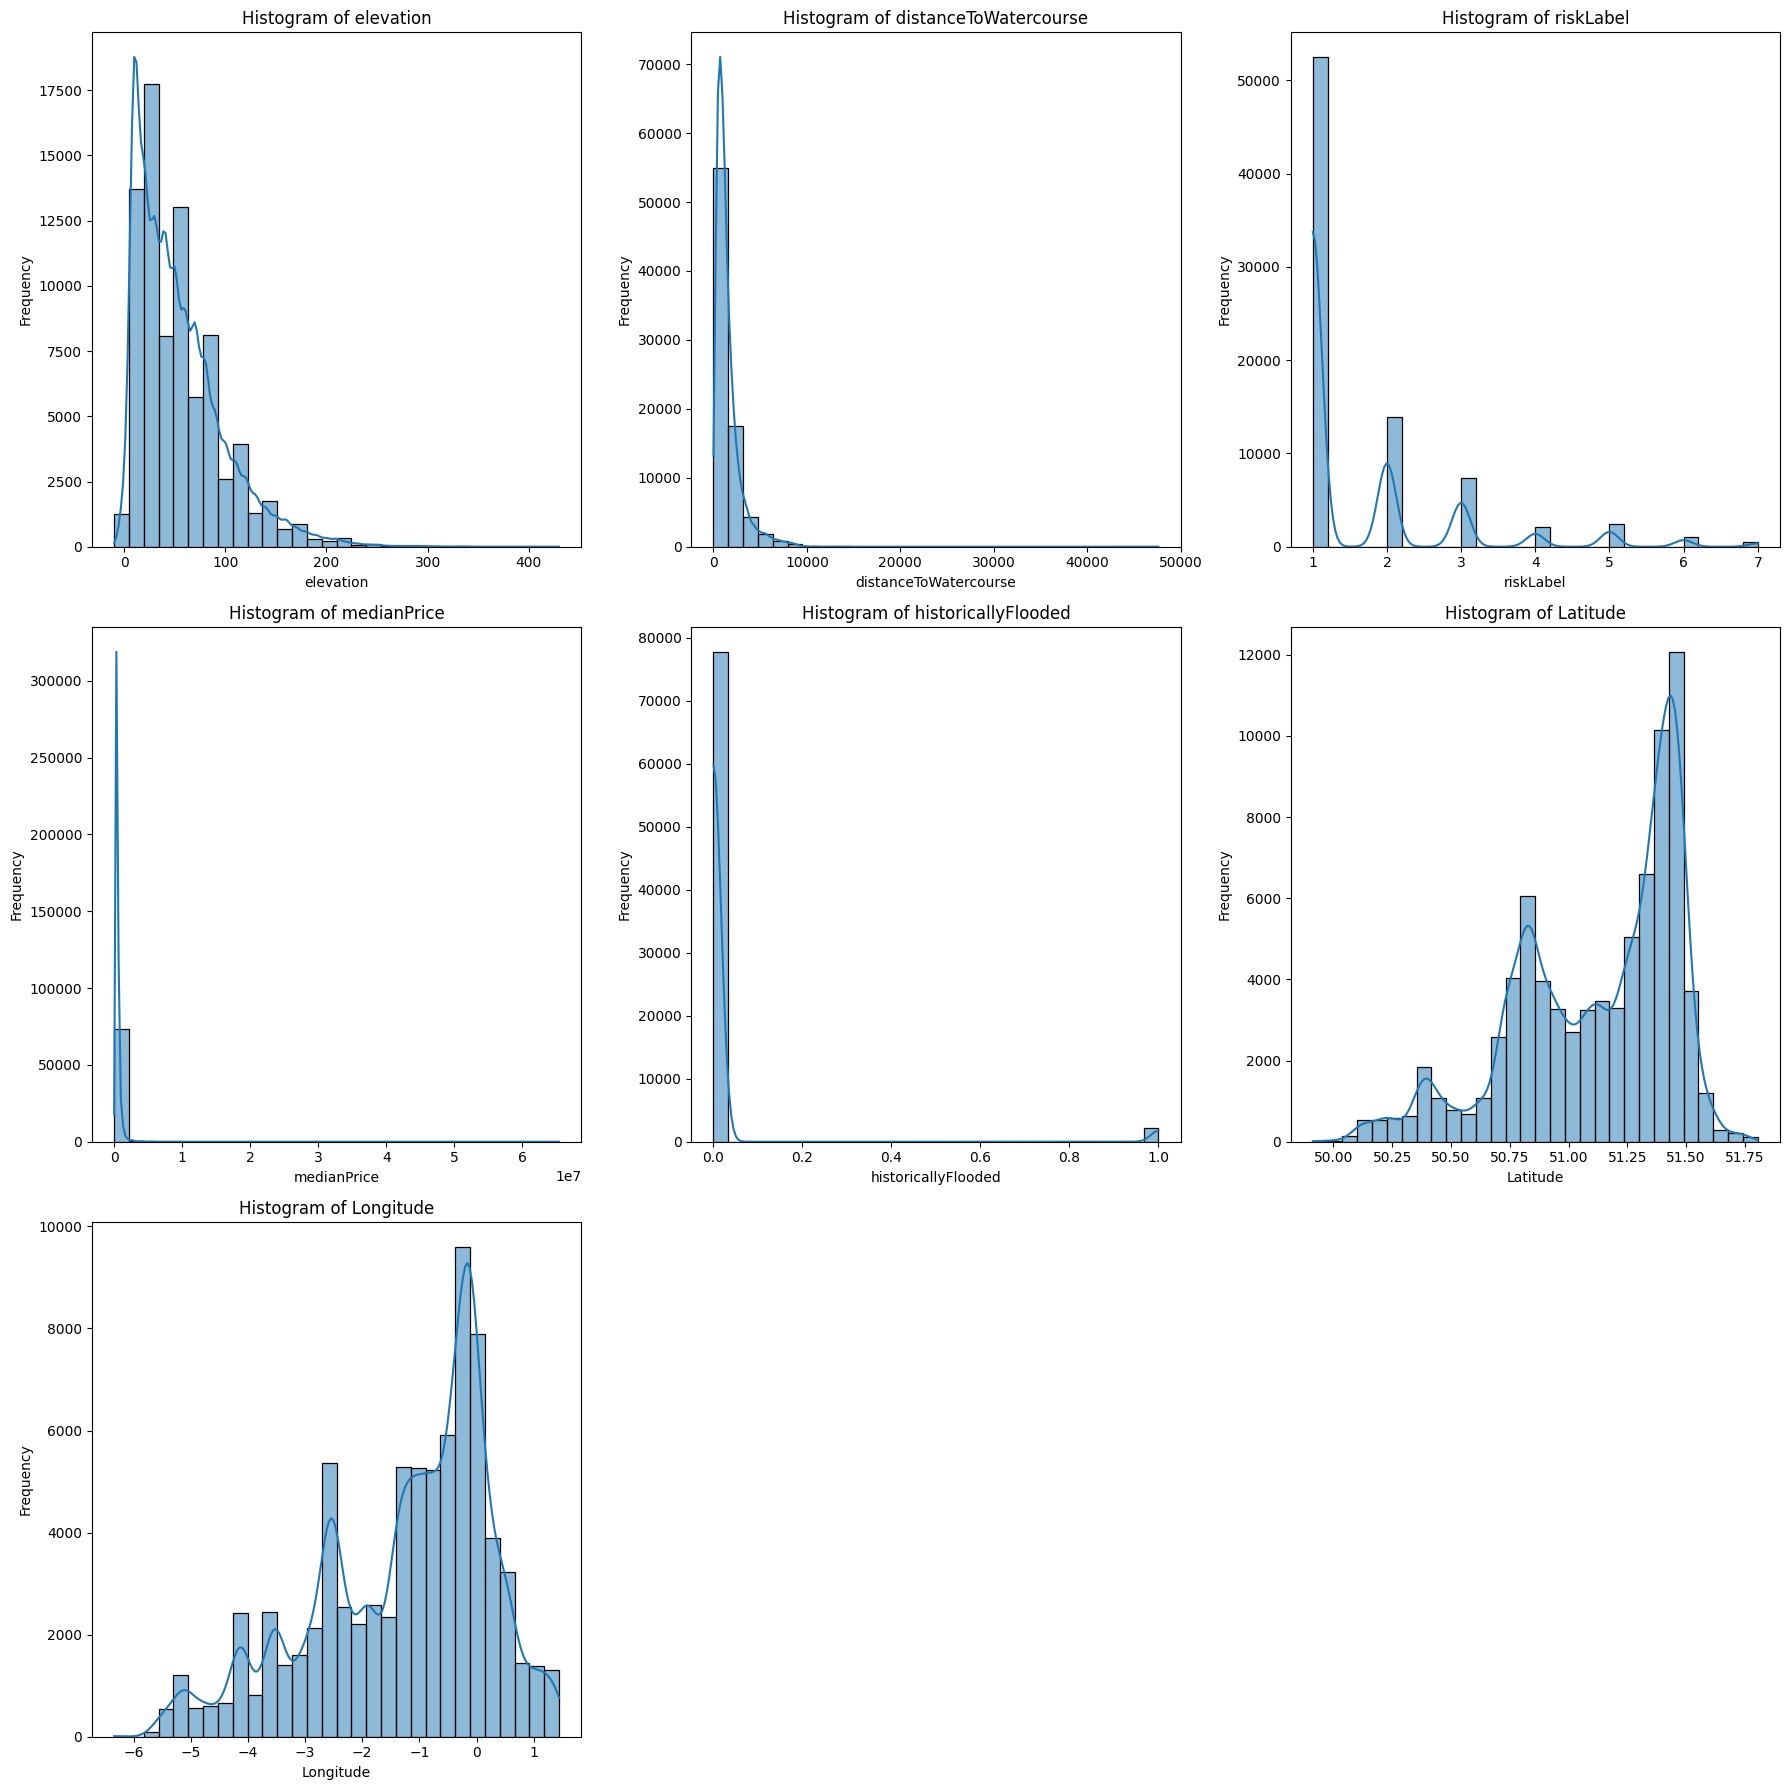

In [31]:
def plot_all_histograms(df, bins=30):
    """
    Plots a histogram for each numeric column in the DataFrame in a grid layout.
    
    Parameters:
    - df: pandas DataFrame with data.
    - bins: int, the number of bins for the histograms.
    """
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    num_cols = len(numeric_cols)
    num_rows = (num_cols + 2) // 3  # Adjust the number of rows based on the number of columns

    fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.histplot(df[col], bins=bins, kde=True, ax=axes[i])
        axes[i].set_title(f'Histogram of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_all_histograms(postcodes_labelled)


#elevation, distacnetoWaterscourse skwewed: robust scaler

<Axes: xlabel='medianPrice'>

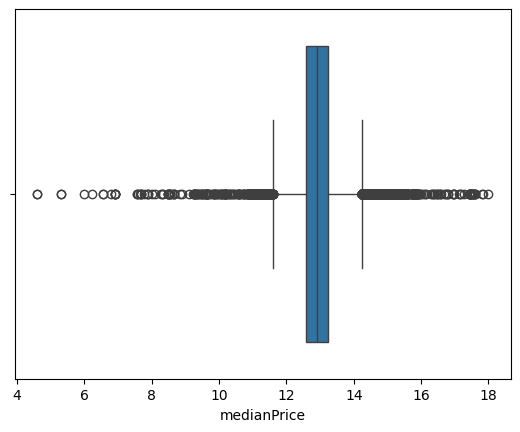

In [32]:
sns.boxplot(np.log(postcodes_labelled['medianPrice']), orient='h')
#4to 11.9, 11.9 to 14.2, 14.2 inf because we want to be rich.


<Axes: ylabel='distanceToWatercourse'>

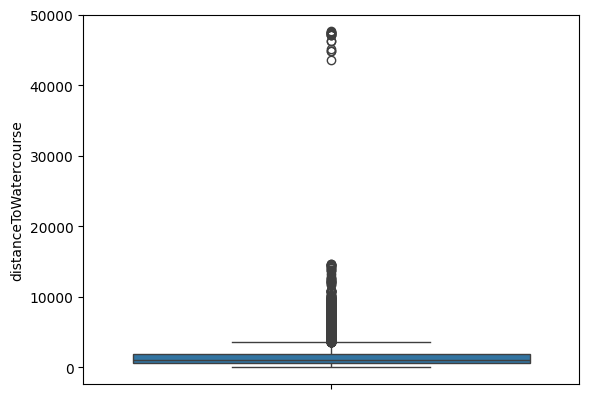

In [33]:
#postocodes_labelled.drop(columns=['easting', 'northing'], inplace=True)
postcodes_labelled.head()
#binning on median Price, 
#how to handle the imbalanced data: do we want to be cautious, or not. 
postcodes_labelled['historicallyFlooded'].value_counts() # Have the postcodes that have been flooded, 
sns.boxplot(postcodes_labelled['distanceToWatercourse'])

<Axes: xlabel='medianPrice'>

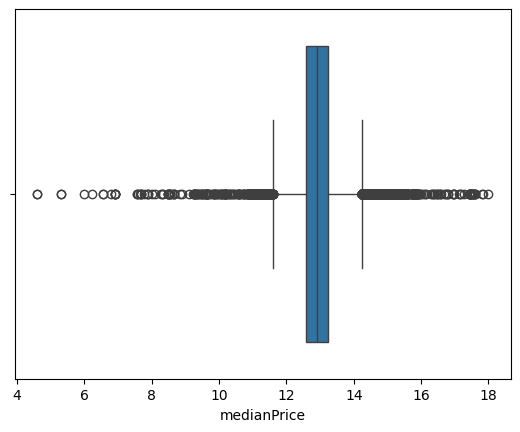

In [34]:
sns.boxplot(np.log(postcodes_labelled['medianPrice']), orient = 'h')

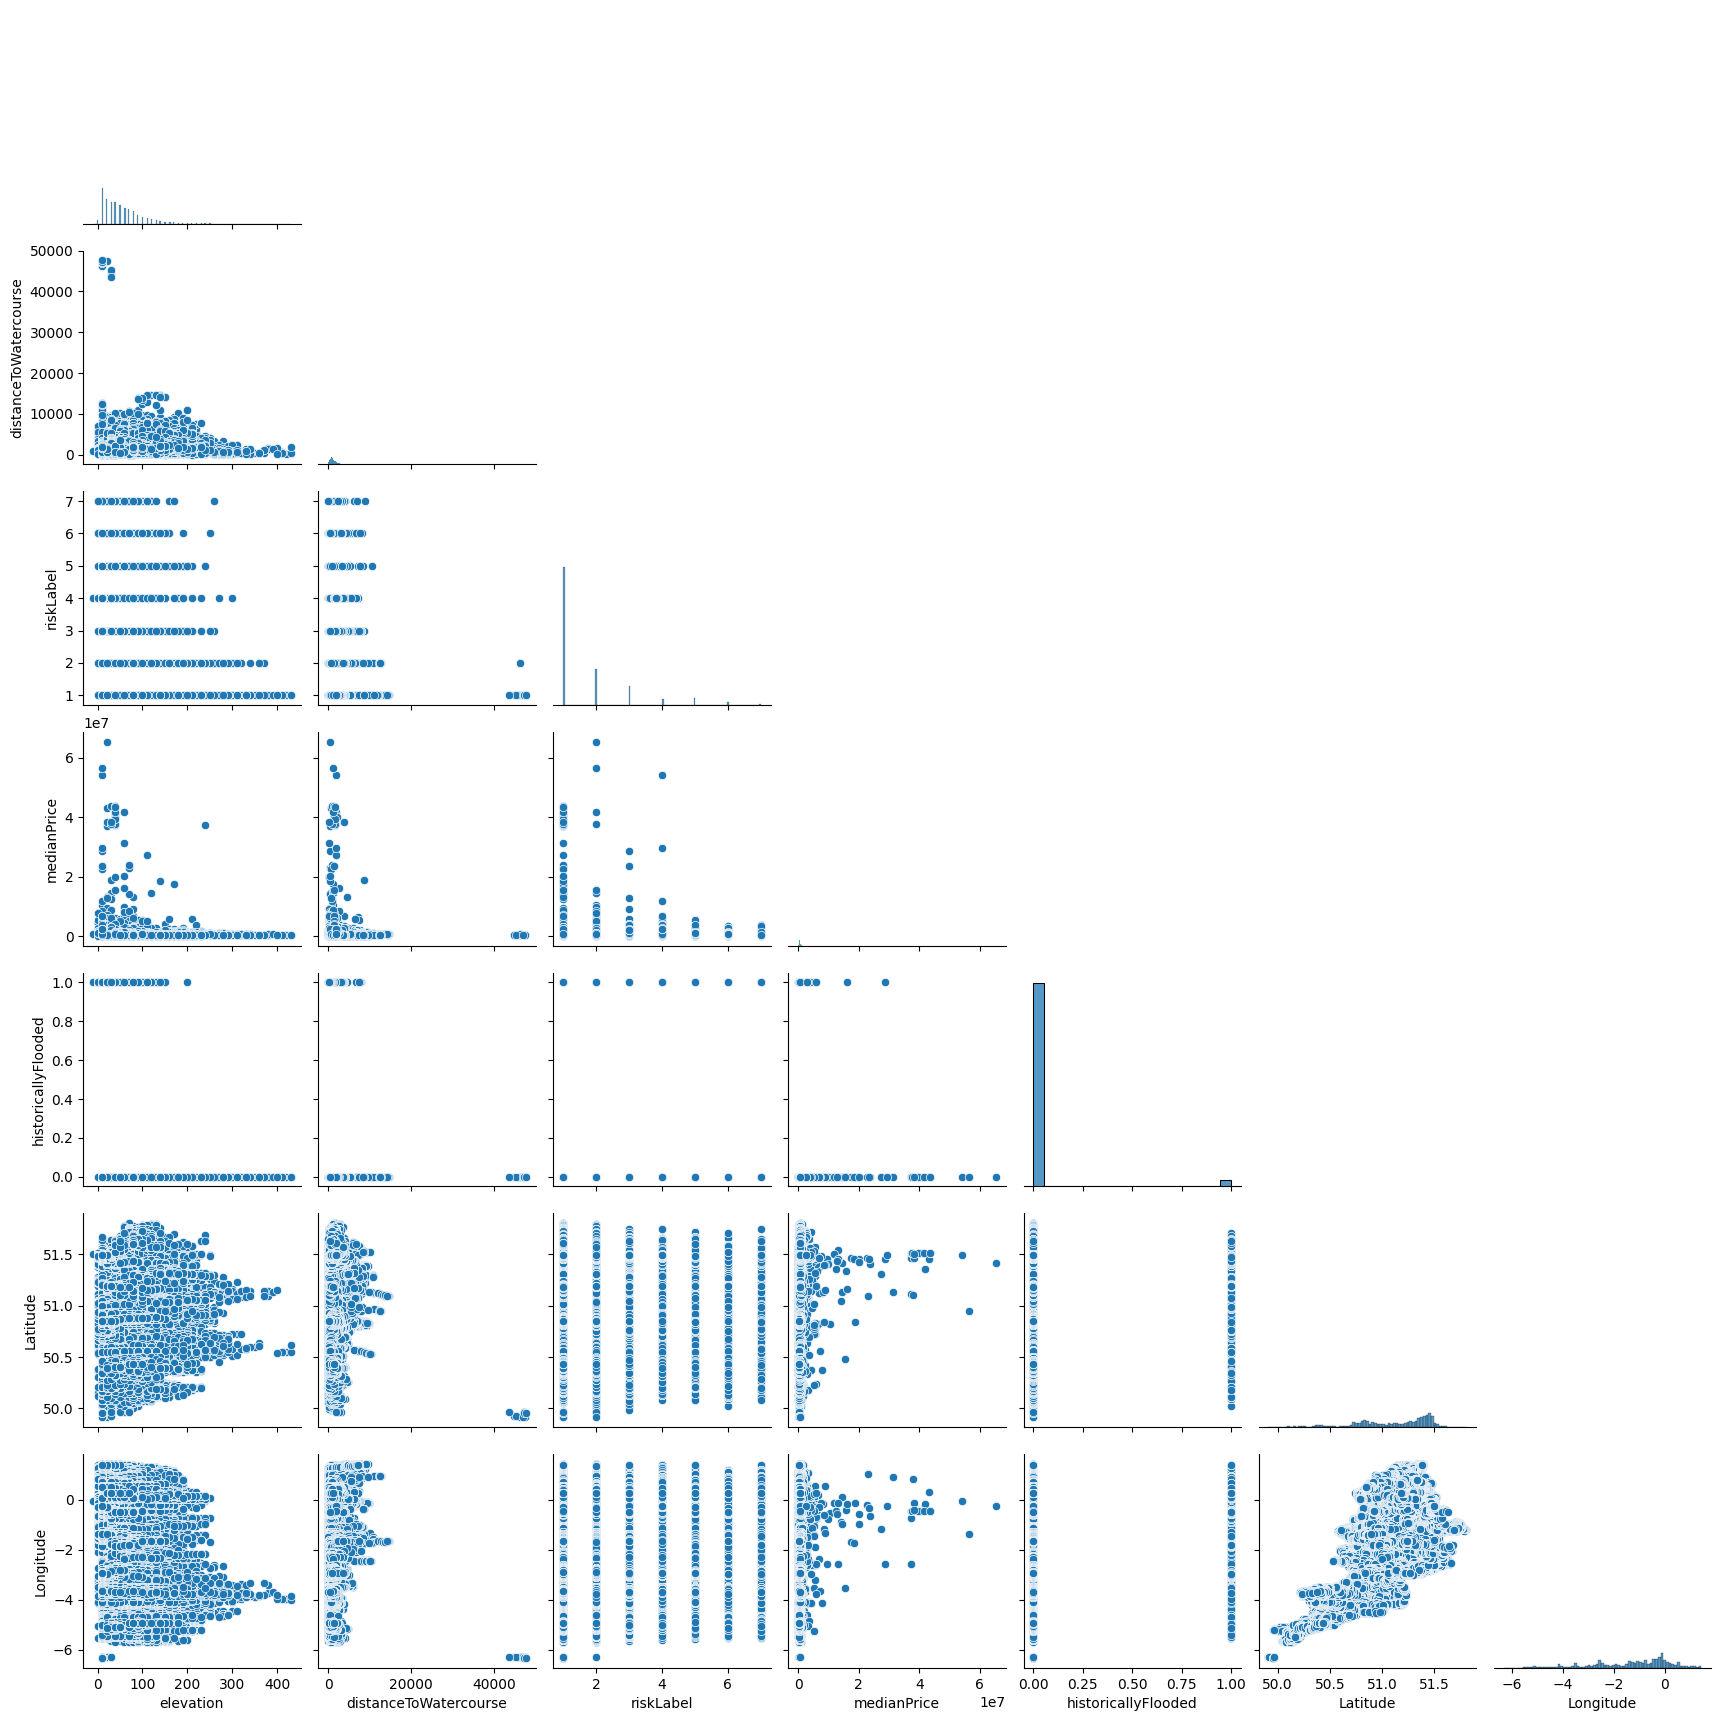

In [35]:
#sns.boxplot(postocodes_labelled['elevation'], orient = 'h')
sns.pairplot(postcodes_labelled, corner = 'True')

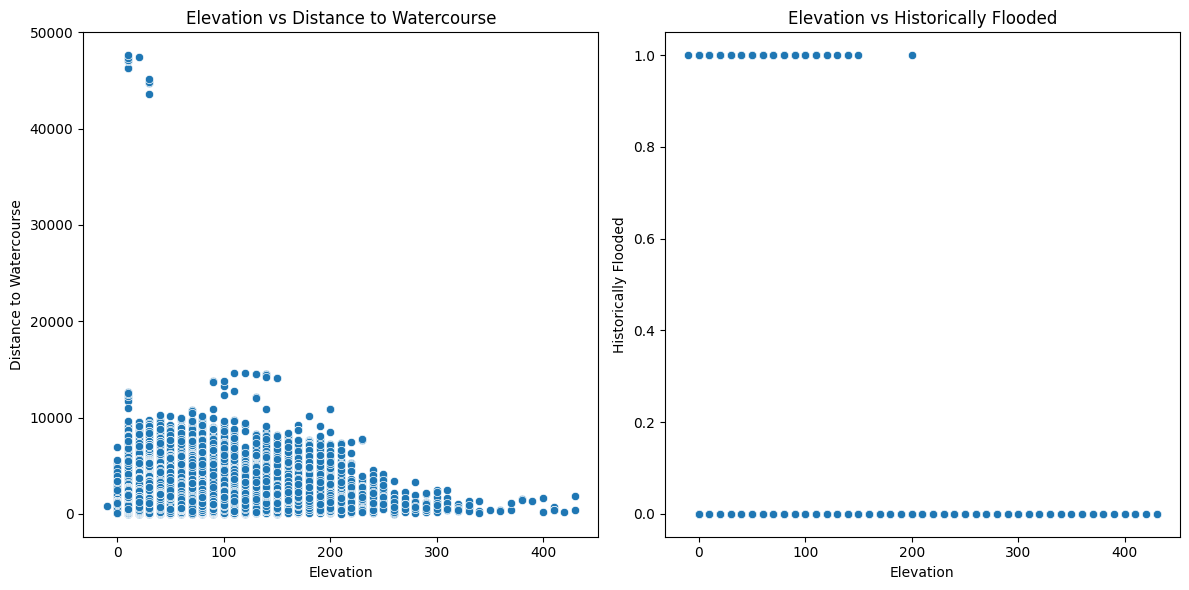

In [36]:
# Plot elevation vs distance to watercourse
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='elevation', y='distanceToWatercourse', data=postcodes_labelled)
plt.title('Elevation vs Distance to Watercourse')
plt.xlabel('Elevation')
plt.ylabel('Distance to Watercourse')

# Plot elevation vs historically flooded
plt.subplot(1, 2, 2)
sns.scatterplot(x='elevation', y='historicallyFlooded', data=postcodes_labelled)
plt.title('Elevation vs Historically Flooded')
plt.xlabel('Elevation')
plt.ylabel('Historically Flooded')

plt.tight_layout()
plt.show()

<Axes: >

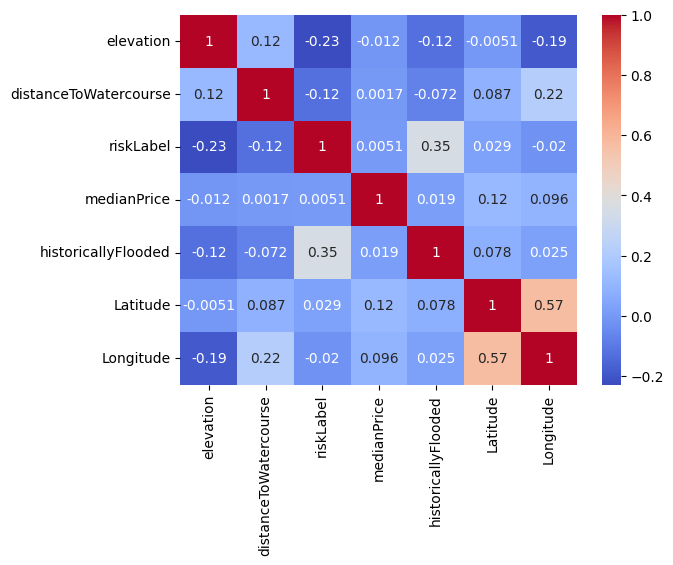

In [37]:
numerical_col = postcodes_labelled.select_dtypes(include=np.number)
sns.heatmap(numerical_col.corr(), annot=True, cmap='coolwarm')

In [38]:
postcodes_labelled['elevation'].describe()

count    80000.000000
mean        54.313500
std         43.631669
min        -10.000000
25%         20.000000
50%         40.000000
75%         80.000000
max        430.000000
Name: elevation, dtype: float64

## Model
## Label Encoder

In [39]:
from sklearn.preprocessing import LabelEncoder

# postcodes_labelled['nearestWatercourse'] = postcodes_labelled['nearestWatercourse'].fillna('Unknown')

label_encoder = LabelEncoder()
postcodes_labelled['localAuthority'] = label_encoder.fit_transform(postcodes_labelled['localAuthority'])
postcodes_labelled['soilType'] = label_encoder.fit_transform(postcodes_labelled['soilType'])
postcodes_labelled['nearestWatercourse'] = label_encoder.fit_transform(postcodes_labelled['nearestWatercourse'])

postcodes_labelled

,postcode,soilType,elevation,nearestWatercourse,distanceToWatercourse,localAuthority,riskLabel,medianPrice,historicallyFlooded,Latitude,Longitude
0,BA1 1AL,9,20,690,1240.0,4,5,621800.0,1,51.379625,-2.363284
1,BA1 1AN,9,20,690,1550.0,4,3,577900.0,0,51.379000,-2.358926
2,BA1 1AR,9,20,690,1540.0,4,5,533300.0,1,51.378585,-2.359282
3,BA1 1BG,9,30,690,1450.0,4,1,563600.0,0,51.383215,-2.359763
4,BA1 1BH,9,30,690,1410.0,4,1,570800.0,0,51.382862,-2.360321
...,...,...,...,...,...,...,...,...,...,...,...
79995,W6 0XA,9,10,840,1790.0,37,4,623000.0,0,51.495196,-0.245247
79996,W6 0XY,9,10,840,2020.0,37,4,2491200.0,0,51.496991,-0.246835
79997,W6 0YE,9,10,840,1940.0,37,4,2469300.0,0,51.496782,-0.244912
79998,WD3 1PZ,6,100,1146,1790.0,35,1,654400.0,0,51.614605,-0.450355


## Pipeline

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN

# Define preprocessing for numeric columns (impute missing values, log transform, and scale)
def log_transform(x):
    return np.log1p(x+np.abs(postcodes_labelled['elevation'].min()))

numeric_features = ['elevation', 'distanceToWatercourse']
numeric_remained = ['Latitude', 'Longitude', 'soilType', 'nearestWatercourse']


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('log_transform', FunctionTransformer(log_transform, validate=True)),
    ('scaler', RobustScaler())
])

numeric_remained_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('num_rem', numeric_remained_transformer, numeric_remained)
    ])

# Define the pipeline
oversample_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
])

standard_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

smoteenn_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smoteenn', SMOTEENN(random_state=42)),
])


In [41]:
oversample_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x7f274d614860>,
                                                                                       validate=True)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['elevation',
                                                   'distanceToWatercourse']),
                                                 ('num_rem',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Latitude', 'Longitude',
                                                   'soilType',
                                                   'nearestWatercourse'])])),
                ('smote', SMOTE(random_state=42))])

In [42]:
standard_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x7f274d614860>,
                                                                                       validate=True)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['elevation',
                                                   'distanceToWatercourse']),
                                                 ('num_rem',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Latitude', 'Longitude',
                                                   'soilType',
                                                   'nearestWatercourse'])]))])

In [ ]:
# Split the data into training and testing sets
X = postcodes_labelled[['elevation', 'distanceToWatercourse', 'Latitude', 'Longitude', 'soilType', 'nearestWatercourse']]
y = postcodes_labelled['historicallyFlooded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
X_train_transformed = standard_pipeline.fit_transform(X_train)
X_test_transformed = standard_pipeline.transform(X_test)



# Random Forest

## Hyper-parameters for RandomizedSearch
(Can be lower than actual performance since I just did a rough preprocessing for missing values, to be solved in the final project with the well-preprocessed data)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# define Random Forest models and params
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [20, 30, 40, 50]
}

## Standard Method without Oversampling

In [ ]:
# Optimizing
rf_search = RandomizedSearchCV(rf, rf_params, cv=5, n_iter=5, scoring='recall_macro', random_state=42)

# Train the model
rf_search.fit(X_train_transformed, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [20, 30, 40, 50],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='recall_macro')

In [45]:
rf_best_t4 = rf_search.best_estimator_
best_params_rf = rf_search.best_params_

y_pred_t4 = rf_best_t4.predict(X_test_transformed)

print(f"The best hyperparameters are: {best_params_rf}")
print('Random Forest Classification Report:\n', classification_report(y_test, y_pred_t4))

The best hyperparameters are: {'n_estimators': 100, 'max_depth': 20}
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15594
           1       0.77      0.43      0.55       406

    accuracy                           0.98     16000
   macro avg       0.88      0.71      0.77     16000
weighted avg       0.98      0.98      0.98     16000



## Oversampling SMOTE

In [46]:
X_train_trans_os, y_train_os = oversample_pipeline.fit_resample(X_train, y_train)

X_test_trans_os = oversample_pipeline['preprocessor'].transform(X_test)


In [47]:
# define Random Forest models and params
rf = RandomForestClassifier(random_state=42)

# Optimizing
rf_search_os = RandomizedSearchCV(rf, rf_params, cv=5, n_iter=5, scoring='recall_macro', random_state=42)

# Train the model
rf_search_os.fit(X_train_trans_os, y_train_os)

rf_os_best_t4 = rf_search_os.best_estimator_
rf_os_best_params_t4 = rf_search_os.best_params_
print(f"The best hyperparameters are: {rf_os_best_params_t4}")

The best hyperparameters are: {'n_estimators': 300, 'max_depth': 40}


In [48]:
y_pred_os_t4 = rf_os_best_t4.predict(X_test_trans_os)

print('Random Forest Classification Report:\n', classification_report(y_test, y_pred_os_t4))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     15594
           1       0.53      0.62      0.57       406

    accuracy                           0.98     16000
   macro avg       0.76      0.80      0.78     16000
weighted avg       0.98      0.98      0.98     16000



## Oversampling SMOTEENN

In [49]:
X_train_trans_smoteenn, y_train_trans_smoteenn = smoteenn_pipeline.fit_resample(X_train, y_train)

X_test_trans_smoteenn = smoteenn_pipeline['preprocessor'].transform(X_test)

In [50]:
# define Random Forest models and params
rf = RandomForestClassifier(random_state=42)

# Optimizing
rf_search_smoteenn = RandomizedSearchCV(rf, rf_params, cv=5, n_iter=5, scoring='recall_macro', random_state=42)

# Train the model
rf_search_smoteenn.fit(X_train_trans_smoteenn, y_train_trans_smoteenn)

rf_smoteenn_best_t4 = rf_search_smoteenn.best_estimator_
rf_smoteenn_best_params_t4 = rf_search_smoteenn.best_params_
print(f"The best hyperparameters are: {rf_smoteenn_best_params_t4}")

The best hyperparameters are: {'n_estimators': 100, 'max_depth': 50}


In [51]:
y_pred_smoteenn_t4 = rf_smoteenn_best_t4.predict(X_test_trans_smoteenn)

print('Random Forest Classification Report:\n', classification_report(y_test, y_pred_smoteenn_t4))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98     15594
           1       0.34      0.72      0.46       406

    accuracy                           0.96     16000
   macro avg       0.67      0.84      0.72     16000
weighted avg       0.98      0.96      0.96     16000



## XGBoosting

## Hyper-parameters

In [53]:
from xgboost import XGBClassifier

# define params
param_grid_xgb = {
    'n_estimators': [300, 400, 500, 600],
    'learning_rate': [0.4, 0.5, 0.6, 0.8],
    'max_depth': [5, 10, 15]
}

## Oversampling Method SMOTE

In [54]:
# define model
xgb = XGBClassifier(random_state=42, eval_metric='logloss')

# RandomizedSearchCV
rs_xgb_os = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid_xgb,
    n_iter=10,
    scoring='recall_macro',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# train
rs_xgb_os.fit(X_train_trans_os, y_train_os)

xgb_os_best_t4 = rs_xgb_os.best_estimator_
xgb_os_best_params_t4 = rs_xgb_os.best_params_
print(f"The best hyperparameters are: {xgb_os_best_params_t4}")



Fitting 5 folds for each of 10 candidates, totalling 50 fits


The best hyperparameters are: {'n_estimators': 600, 'max_depth': 10, 'learning_rate': 0.5}


In [55]:
y_pred_xgb_os_t4 = xgb_os_best_t4.predict(X_test_trans_os)

print('XGBoosting Classification Report:\n', classification_report(y_test, y_pred_xgb_os_t4))

XGBoosting Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     15594
           1       0.49      0.60      0.54       406

    accuracy                           0.97     16000
   macro avg       0.74      0.79      0.76     16000
weighted avg       0.98      0.97      0.98     16000



## SMOTEENN

In [56]:
# RandomizedSearchCV
rs_xgb_enn = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid_xgb,
    n_iter=10,
    scoring='recall_macro',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# train
rs_xgb_enn.fit(X_train_trans_smoteenn, y_train_trans_smoteenn)

xgb_enn_best_t4 = rs_xgb_enn.best_estimator_
xgb_enn_best_params_t4 = rs_xgb_enn.best_params_
print(f"The best hyperparameters are: {xgb_enn_best_params_t4}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best hyperparameters are: {'n_estimators': 600, 'max_depth': 10, 'learning_rate': 0.5}


In [57]:
y_pred_xgb_enn_t4 = xgb_enn_best_t4.predict(X_test_trans_smoteenn)

print('XGBoosting Classification Report:\n', classification_report(y_test, y_pred_xgb_enn_t4))

XGBoosting Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98     15594
           1       0.32      0.71      0.44       406

    accuracy                           0.95     16000
   macro avg       0.65      0.84      0.71     16000
weighted avg       0.98      0.95      0.96     16000



### I think Random Forest + SMOTE can be best model in this task.